In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
data = pd.read_csv('comp_occur.csv')

In [3]:
# Separate features and labels
features = data[[f'V{i}' for i in range(1, 40)]]
labels = data['Fold']

# Label encode the target
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [ ]:
# PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(scaled_features)

In [5]:
# UMAP
umap_reducer = umap.UMAP(n_components=2,  metric='euclidean')
umap_result = umap_reducer.fit_transform(pca_result)
# Plotting PCA results

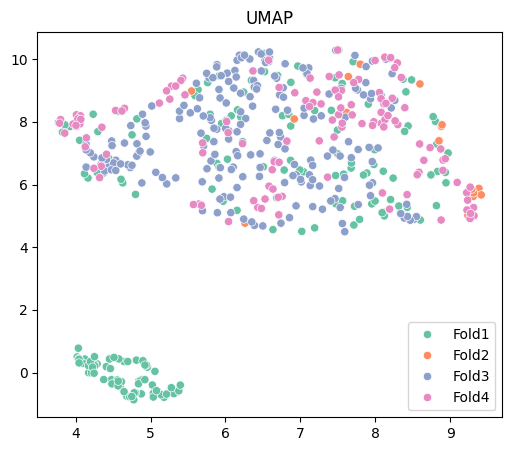

In [6]:
def plot_embedding(embedding, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='Set2')
    plt.title(title)
    plt.legend()
    plt.show()


plot_embedding(umap_result, "UMAP")


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings

In [7]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels_encoded, test_size=0.2, stratify=labels_encoded)


In [15]:
CV_FOLDS = 5

In [18]:
# %% Define Models and Pipelines
print("Defining models and pipelines (with class weights for SVC/RF)...")

# K-Nearest Neighbors (No class_weight option)
knn = KNeighborsClassifier(n_neighbors=18, metric='minkowski', p=2.5)
pipe_knn = Pipeline([
    ('knn', knn)
])

# Support Vector Classifier (with class_weight)
svc = SVC(kernel='rbf', decision_function_shape='ovo',
          probability=True, class_weight='balanced') # <<< Added class_weight
pipe_svc = Pipeline([
    ('svc', svc)
])

# Random Forest Classifier (with class_weight)
rf = RandomForestClassifier(n_estimators=10000, criterion='entropy',
                            n_jobs=-1, class_weight='balanced') # <<< Added class_weight
pipe_rf = Pipeline([
    ('rf', rf)
])

models = {
    "KNN": pipe_knn,
    "SVC_balanced": pipe_svc,         # Renamed for clarity
    "RandomForest_balanced": pipe_rf # Renamed for clarity
}

# %% Train and Evaluate Models
print("Training and evaluating models...")

for name, model_pipeline in models.items():
    print(f"--- Evaluating {name} ---")

    # --- Cross-Validation ---
    print(f"Running {CV_FOLDS}-fold cross-validation...")
    cv_scores = cross_val_score(estimator=model_pipeline,
                                X=X_train,
                                y=y_train,
                                cv=CV_FOLDS,
                                scoring='accuracy',
                                n_jobs=-1)

    print(f"CV Accuracy ({CV_FOLDS}-fold): {cv_scores.mean()*100:.2f} % (+/- {cv_scores.std()*100:.2f} %)")

    # --- Test Set Evaluation ---
    print("Evaluating on the independent test set...")
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Added zero_division=0 to handle potential division by zero without warning
    class_report = classification_report(y_test, y_pred, zero_division=0,
                                         target_names=le.classes_) # Add target names

    print(f"Test Set Accuracy: {test_accuracy*100:.2f} %")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("-------------------------\n")

print("Script finished.")


Defining models and pipelines (with class weights for SVC/RF)...
Training and evaluating models...
--- Evaluating KNN ---
Running 5-fold cross-validation...
CV Accuracy (5-fold): 64.85 % (+/- 5.21 %)
Evaluating on the independent test set...
Test Set Accuracy: 64.76 %
Confusion Matrix:
[[16  0 12  7]
 [ 0  0  0  3]
 [ 1  0 39  2]
 [ 1  0 11 13]]
Classification Report:
              precision    recall  f1-score   support

       Fold1       0.89      0.46      0.60        35
       Fold2       0.00      0.00      0.00         3
       Fold3       0.63      0.93      0.75        42
       Fold4       0.52      0.52      0.52        25

    accuracy                           0.65       105
   macro avg       0.51      0.48      0.47       105
weighted avg       0.67      0.65      0.63       105

-------------------------

--- Evaluating SVC_balanced ---
Running 5-fold cross-validation...
CV Accuracy (5-fold): 70.81 % (+/- 2.48 %)
Evaluating on the independent test set...
Test Set Accura